# Blog: 深度解读 Policy Gradient, PPO & PPG

linnk: https://zhuanlan.zhihu.com/p/342150033

## Policy Gradient method

## GAE (Generalized Advantage Estimation)

$TD(\lambda)$- like advantage estimation

In practice, instead of using infinite-length horizon, sample a fixed length of nstep, program it in a recursive manner.

In [ ]:
import torch
def compute_gae(
    vpred, # "value predictions",
    reward,
    first, # "mark beginning of episodes"
    gamma,
    lambda_gae
):
    orig_device = vpred.device
    assert orig_device == reward.device == first.device
    vpred, reward, first = (x.to('cpu') for x in (vpred, reward, first))
    assert first.dim() == 2
    nenv, nstep = reward.shape
    assert vpred.shape == first.shape == (nenv, nstep + 1)
    adv = torch.zeros([nenv, nstep], dtype=torch.float32)
    lastgaelam = 0
    
    for t in reversed(range(nstep)):
        notlast = 1 - first[:,t+1]
        nextvalue = vpred[:t+1]
        delta = reward[:,t] + gamma * nextvalue - vpred[:,t]
        adv[:,t] = lastgaelam = delta + notlast * gamma * lambda_gae * lastgaelam

    vtarg = vpred[:,:-1] + adv
    return adv.to(orig_device), vtarg.to(orig_device)


**Note**

Here we need have an extra step for value(vpred) and terminal(first) to calculate the desired gae and value target.

## Calculation of log likelihood

For discrete action space, it is a Catergorical Distribution.

For continuous action space, it is usually a Gaussian Distribution.

In [ ]:
# Gumbel max sampling in openai baseline
import tensorflow as tf
def sample(self):
    u = tf.random_uniform(tf.shape(self.logits), dtype=self.logits.dtype)
    return tf.argmax(self.logits - tf.log(-tf.log(u)), axis=-1)

# equivalent to multinomial sampling yet more efficient

### Gumbel Distribution

<div align="center">
<img src=asset/gumbel1.png  width=50%/>

<div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Gumbel Distribution</div>

<br>

the Gumbel distribution is typically used to model the maximum of a set of independent samples, and it should be a good fit when the underlying data is distributed according to either a normal or an exponential distribution. Furthermore, the multinomial random choice of a discrete distribution can be viewed as the operation of argmax on original logit plus a gumbel noise.

The Gumbel-Max Trick for Discrete Distributions.

link: https://hips.seas.harvard.edu/blog/2013/04/06/the-gumbel-max-trick-for-discrete-distributions

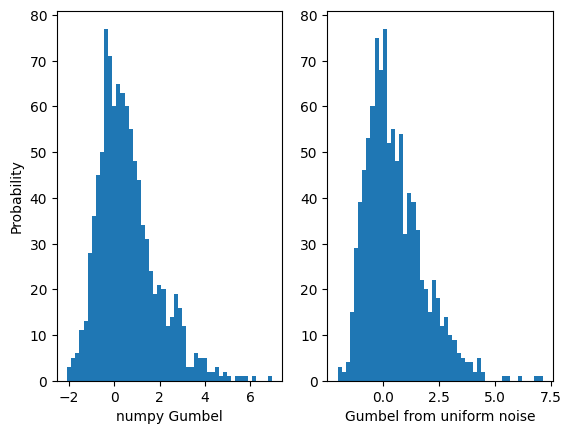

In [19]:
# Manually generating Gumbel Distribution from uniform distribution
from matplotlib.pyplot import *
import numpy as np
from numpy import log
n_samples = 1000
numpy_gumbel = np.random.gumbel(size=n_samples)
manual_gumbel = -log(-log(np.random.uniform(size=n_samples)))
figure()
subplot(1, 2, 1)
hist(numpy_gumbel, bins=50)
ylabel("Probability")
xlabel("numpy Gumbel")
subplot(1, 2, 2)
hist(manual_gumbel, bins=50)
xlabel("Gumbel from uniform noise")

### The Gumbel-softmax trick
Remember, the Gumbel-max trick produces a sample by adding noise to the logits then taking the argmax of the resulting vector. So far, there's nothing so special about Gumbel-max sampling.

But what if we approximate the argmax by a (low-temperature) softmax? Then something really interesting happens: we have a chain of operations that's fully differentiable. We have differentiable sampling operator (albeit with a soft one-hot output instead of a scalar). Wow!

<div align="center">
<img src=asset/differentiable_argmax.webp  width=60%/>

<div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Differentiable argmax in a NN</div>

<br>



## PPO

PPO is an improvement on  vanilla pocily gradient, inheriting from TRPO.

The biggest problem of PG methods is the bias of data distribution, deriving from a biased estimate of Advantage function. Therefore, if an update of policy is too far off, the next sampling will be dramatically off road, inducing a malicious cycle. TRPO addresses this problem by keeping policy updates in a trust region.

### Use of importance sampling

PG mthods are on policy, therefore sampling inefficient. For TRPO and PPO, they are mostly off-policy, or near on-policy due to sanple reuse.

For PPO, usually we have sample_reuse = 3. (one on-policy update, the others are off-policy)

Hence, we use IS to adjust.

<div align="center">
<img src=asset/is.png  width=60%/>

<div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">Importance Sampling</div>

<br></div>

### Clipped Surrogate Objective

<div align="center">
<img src=asset/clip.webp width=80%/>

<div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">clip-PPO</div>
</div>

The idea of PPO is  that we clip the ratio of current and old policies, if the ratio exceeds $\epsilon$, it will be clipped, and the gradient will be zero, stopping further deviation

### Basic Training Flow

<div align="center">
<img src=asset/algorithm.webp width=60%/>

<div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">PPO</div>
</div>

Common setting: K = 3, minibatch_size = NT/4. That means 12 updates per sampling.

### OpenAI Dota Five

$$Sample Reuse := \frac{(sample \space per \space batch) \times (batches \space per \space second)}{(experience \space buffer \space intake \space samples \space per \space second)}$$

Sample reuse means sample use by learner per second divided by sample generation per second, thus can be smaller than 1.

Experiments show that lower sample reuse imporve model perfermance, this is due to the huge batchsize and up to 32 updates in a single iteration, which is more than sufficient to update value function, unlike in small-scale scenario. In the practice by OpenAI, sample reuse is  0.8-2.7, and sample rerun is 1.0-1.1, implying avoiding sample rerun.

<div align="center">
<img src=asset/openai_five.webp width=80%/>

<div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">OpenAI Five</div>
</div>


### PPO Loss

PPO loss contains three parts: policy loss, value funtion loss and entropy loss.

Common setting: $c_2 = 0.01 \rightarrow 0.001, \space learning rate = 5\times 10^{-5} \rightarrow 5 \times 10^{-6}$

### Clipping and Normalization for Obs, Reward and Advantage 

To make PPO work for differnet game scenario, clipping and normalization are key.

Usually, we do clipping after noramlization.

Advantage normalization is direct, and can be operated on batch data, assuming that advantage has stable distribution.

For rewards, we use running avg.


In [ ]:
class RewardNoramlizer:
    def __init__(self, num_envs, cliprew=10.0, gamma=0.99, epsilon=1e-8, per_env=False) -> None:
        ret_rms_shape =(num_env,) if per_env else ()
        self.ret_rms = RunningMeanStd(shape=ret_rms_shape)
        self.cliprew = cliprew
        self.ret = th.zeros(num_envs)
        self.gamma = gamma
        self.epsilon = epsilon
        self.per_env = per_env
    
    def __call__(self, reward, first):
        rets = backward_discounted_sum(
            prevret=self.ret, reward=reward.cpu(), fisrt=first.cpu(), gamma=self.gamma
        )
        self.ret = ret[:,-1]
        self.ret_rms.update(rets if self.per_env else rets.reshape(-1))
        return self.transform(reward)
    
    def transform(self, reward):
        return th.clamp(
            reward / th.sqrt(self.ret_rms.var + self.epsilon),
            -self.cliprew,
            self.cliprew,
        )

In [ ]:
# observation normalization

def _normalize_clip_observation(x, clip_range=[-5.0, 5.0]):
    rms = RunningMeanStd(shape=x.shape[1:])
    norm_x = tf.clip_by_value((x - rms.mean) / rms.std, min(clip_range), max(clip_range))
    return norm_x, rms

**Note**

Recommendation: Always use observation normalization and check if value function normalization improves performance. Gradient clipping might slightly help but is of secondary importance.

### Network Initialization

In PPG, the neural network uses Normalized Fan-in init(std is calculated using the norm of fan-in weights)

In [ ]:
def NormedLinear(*args, scale=1.0, dtype=th.float32, **kwargs):
    """
    nn.Linear but with normalized fan-in init
    """
    dtype = parse_dtype(dtype)
    if dtype == th.float32:
        out = nn.Linear(*args, **kwargs)
    elif dtype == th.float16:
        out = LinearF16(*args, **kwargs)
    else:
        raise ValueError(dtype)
    out.weight.data *= scale / out.weight.norm(dim=1, p=2, keepdim=True)
    if kwargs.get("bias", True):
        out.bias.data *= 0
    return out

def NormedConv2d(*args, scale=1, **kwargs):
    """
    nn.Conv2d but with normalized fan-in init
    """
    out = nn.Conv2d(*args, **kwargs)
    out.weight.data *= scale / out.weight.norm(dim=(1, 2, 3), p=2, keepdim=True)
    if kwargs.get("bias", True):
        out.bias.data *= 0
    return out

In [ ]:
def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(tensor, mode) 
    # 通过mode判断是前向传播还是反向传播, 生成不同的一个fan值.
    gain = calculate_gain(nonlinearity, a)
    # 通过判断是哪种激活函数生成一个gain值
    std = gain / math.sqrt(fan) # 通过fan值和gain值进行标准差的计算
    with torch.no_grad():
        return tensor.normal_(0, std)

def _calculate_fan_in_and_fan_out(tensor):
    dimensions = tensor.dim() # 返回的是维度
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    if dimensions == 2:  # Linear
        fan_in = tensor.size(1) 
        fan_out = tensor.size(0)
    else:
        num_input_fmaps = tensor.size(1) # 卷积的输入通道大小
        num_output_fmaps = tensor.size(0) # 卷积的输出通道大小
        receptive_field_size = 1
        if tensor.dim() > 2:
            receptive_field_size = tensor[0][0].numel() # 卷积核的大小:k*k
        fan_in = num_input_fmaps * receptive_field_size # 输入通道数量*卷积核的大小. 用于前向传播
        fan_out = num_output_fmaps * receptive_field_size # 输出通道数量*卷积核的大小. 用于反向传播

    return fan_in, fan_out

def _calculate_correct_fan(tensor, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError("Mode {} not supported, please use one of {}".format(mode, valid_modes))

    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out

def calculate_gain(nonlinearity, param=None):
    r"""Return the recommended gain value for the given nonlinearity function.
    The values are as follows:

    ================= ====================================================
    nonlinearity      gain
    ================= ====================================================
    Linear / Identity :math:`1`
    Conv{1,2,3}D      :math:`1`
    Sigmoid           :math:`1`
    Tanh              :math:`\frac{5}{3}`
    ReLU              :math:`\sqrt{2}`
    Leaky Relu        :math:`\sqrt{\frac{2}{1 + \text{negative\_slope}^2}}`
    ================= ====================================================

    Args:
        nonlinearity: the non-linear function (`nn.functional` name)
        param: optional parameter for the non-linear function

    Examples:
        >>> gain = nn.init.calculate_gain('leaky_relu', 0.2)  # leaky_relu with negative_slope=0.2
    """
    linear_fns = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d']
    if nonlinearity in linear_fns or nonlinearity == 'sigmoid':
        return 1
    elif nonlinearity == 'tanh':
        return 5.0 / 3
    elif nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            # True/False are instances of int, hence check above
            negative_slope = param
        else:
            raise ValueError("negative_slope {} not a valid number".format(param))
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    else:
        raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))

Initialize the last policy layer with 100x smaller weights. Use softplus function $ln(1 + e^x)$ to transform network output into action and add a negative offset to its input to decrease the initial std of actions. Tune this offset if possible. Use tanh both as the activation function (if the networks are not too deep) and to transform the samples from the normal distribution to the bounded action space. Use a wide value MLP (no layers shared with the policy) but tune the policy width(it might need to be narrower than the calue MLP)

初始化最后策略层的权重：建议在初始化策略网络的最后一层时，使用比正常小100倍的权重。这样做的目的可能是为了减缓学习过程的开始阶段，防止在训练初期出现过大的动作（actions）输出，从而有助于稳定训练过程。

使用softplus函数转换网络输出为动作的标准差：在强化学习中，动作的不确定性是一个重要的因素。softplus函数（σ(x) = ln(1 + e^x)）是一个平滑且单调递增的函数，它能够将网络的输出转换为一个正的标准差值，这对于实现动作的不确定性模型（如高斯策略）非常有用。

添加负偏移以减小初始动作的标准差：在softplus函数之前添加一个负偏移量，可以进一步减小初始动作的标准差。这样做可以确保在训练开始时，策略不会生成过大的动作，有助于避免潜在的不稳定性。

调整偏移量：如果可能的话，应该调整这个偏移量以优化性能。这可能涉及到超参数调优的过程，通过实验找到最佳的偏移量。

使用tanh作为激活函数：如果网络不是太深，可以使用tanh（双曲正切函数）作为激活函数。tanh函数的输出范围是[-1, 1]，这使得它适合用于将网络输出规范化到一个有界的动作空间。

使用宽度较大的值网络（Value MLP）：值网络（value network）用于估计状态的预期回报。建议使用一个宽度较大的多层感知机（MLP），但不与策略网络共享层。这样做可以提高值网络的表达能力，更准确地估计值函数。

调整策略宽度：策略网络的宽度（即层的数量和每层的神经元数量）可能需要根据实际情况进行调整。有时，为了控制动作的方差，可能需要一个比值网络更窄的策略网络。

**Recommendation**

Paper: https://arxiv.org/abs/2006.05990

+ Policy losses: Use the PPO policy loss. Start with the clipping threshold set to 0.25, but also try lower and higher values if possible.
+ Networks architecture: see above
+ Normalization and clipping: Always use obs norm and check if value function norm improves performance. Gradient clipping might slightly help but is of secondary importance.
+ Advantage Estimation: Use GAE with $\lambda = 0.9$ but neither Huber loss(combining MSE and MAE) nor PPO-style value loss clipping for value net training.
+ Training setup: Go over experience multiple times. Shuffle individual transitions before assigning them to minibatches and recompute advantages once per data pass. For faster wall-clock time training use many parallel environments and increase batch size(both might hurt the sample complexity). Tune the number of transitions in each iteration if possible.
+ Timesteps handling: Discount factor $\gamma$ is one of the most important hyperparameters and should be tuned per environment(start with $\gamma = 0.99$). Try frame skip if possible. There is no need to handle environments step limits in a special way for large step limits.
+ Use Adam optimizer with momentum $\beta_1 = 0.9$ and a tuned learning rate(3e-4 is a safe default). Linearly decaying the learnign rate may slightly improve performance but is of secondary importance.
+ Regularization: We do not find evidence that any of the investigated regularizers helps significantly on our environments with the exception of HalfCheetah on which all constraints (especially the entropy constraint) help . However, the performance boost is largely independent on the constraint threshold which suggests that the effect is caused by the initial high strength of the penalty (before it gets adjusted) and not by the desired constraint. While it is a bit surprising that regularization does not help at all (apart from HalfCheetah), we conjecture that regularization might be less important in our experiments because: (1) the PPO policy loss already enforces the trust region which makes KL penalties or constraints redundant; and (2) the careful policy initialization (See Sec. 3.2) is enough to guarantee good exploration and makes the entropy bonus or constraint redundant.

### PPG

![pic](asset/ppg.webp)


![pic](asset/ppg2.webp)

Experiments from PPG show that value funtion should be trained more, and for policy training, sample reuse should be close to 1.

[]

In [ ]:
###

In [30]:
import torch
a = torch.tensor([[1,2,3],[3,4,5]], dtype=float)
a.norm(dim=1, p=2,keepdim=True)

tensor([[3.7417],
        [7.0711]], dtype=torch.float64)

In [9]:
probs = np.random.randint(low=1, high=20, size=n_cats)
probs = probs / sum(probs)
logits = np.log(probs)

In [12]:
probs = np.random.randint(low=1, high=20, size=n_cats)
probs

array([19, 17,  4,  6, 15, 14, 14])

In [13]:
noise = np.random.uniform(size=7)

In [14]:
noise

array([0.83017322, 0.35003149, 0.75920581, 0.6238727 , 0.38383317,
       0.23929903, 0.06951028])